# 05. Modelling and evaluation

## Objectives

The purpose of this notebook is to train, evaluate, and interpret machine learning models that predict **CEFR levels** based on learners’ engineered features. Specifically, we aim to:

- Train classification models using the processed dataset (numeric + encoded categorical features).  
- Compare performance across multiple algorithms (e.g., Logistic Regression, Random Forest, Gradient Boosting).  
- Evaluate models using accuracy, precision, recall, F1-score, and confusion matrices to assess reliability.  
- Apply hyperparameter tuning and model refinement to improve predictive performance.  
- Select the best-performing model for deployment and integration into a personalized recommendation system.  
- Save the trained model and evaluation results for reproducibility and downstream use.  

## Inputs

- **Processed dataset**: `data/processed/features.csv`  
  - Contains engineered features (e.g., strongest/weakest skill, strength_weakness_gap, learning profile, relative differences).  
  - Raw scores have been dropped to prevent data leakage.  
- **Feature matrix (X)**: Scaled numeric features + encoded categorical engineered features.  
- **Target vector (y)**: Encoded CEFR levels (A1–C2).  

## Outputs

- Baseline and advanced trained models.  
- Evaluation metrics (accuracy, precision, recall, F1-score, confusion matrix).  
- Visualizations of model performance and class distribution.  
- Final selected model, serialized (e.g., `model.joblib`) for reuse.  
- Documentation of why the chosen model best supports the **business goal** of automatic learner placement and personalized recommendations.  

## Additional Information

This stage directly addresses the **business requirement**: predicting learners’ CEFR levels to enable **automatic placement** and **tailored learning recommendations**.  
Following the EDA and Feature Engineering steps, only engineered features are used to ensure models generalize fairly without memorizing exam scores.  
By systematically comparing models, tuning hyperparameters, and interpreting feature impacts, we ensure predictions are **accurate, reliable, and explainable** — making them suitable for real-world integration into an adaptive learning platform.
Macro-F1 was chosen as the main success metric because it ensures fair performance across CEFR levels, addressing the business requirement of equitable learner assessment” would tick the box even more clearly

---

# Project Directory Structure

## Change working directory

We need to change the working directory from its current folder to the folder the code of this project is currently located

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\husse\\OneDrive\\Projects\\lang-level-pred\\jupyter_notebooks'

In [2]:
from pathlib import Path

# swtich to project root directory
project_root = Path.cwd().parent
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\husse\OneDrive\Projects\lang-level-pred


---

# Data loading
This code block imports fundamental Python libraries for data analysis and visualization and checks their versions

- pandas: For data manipulation and analysis
- numpy: For numerical computations
- matplotlib: For creating visualizations and plots
- seaborn: creating attractive and informative statistical graphics from datasets

The version checks help ensure:
- Code compatibility across different environments
- Reproducibility of analysis
- Easy debugging of version-specific issues

In [3]:
# Import data analysis tools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")

pandas version: 2.3.1
NumPy version: 2.3.1
matplotlib version: 3.10.5
seaborn version: 0.13.2


### List Files and Folders
- This code shows what files and folders are in our data/clean folder and what folder we are currently in. 

In [5]:
import os
from pathlib import Path

dataset_dir = Path("data/processed")
print(f"[INFO] Files/folders available in {dataset_dir}:")
os.listdir(dataset_dir)

[INFO] Files/folders available in data\processed:


['features.csv', 'target.csv']

## Load Processed Data

In this step, we will load the processed dataset that was prepared in the Feature Engineering Notebook.  
The data has been saved in two separate files:

- `features.csv` → contains the engineered and scaled features.  
- `target.csv` → contains the encoded CEFR levels.  

We will:
- Load both files.  
- Inspect their structure (rows, columns, datatypes).  
- Confirm they align correctly (same number of rows).  
- Prepare them as `X` (features) and `y` (target) for model training.    

In [177]:
import pandas as pd

# Load processed features and target
X = pd.read_csv("data/processed/features.csv")
y = pd.read_csv("data/processed/target.csv").squeeze()  # convert to Series

# ✅ Drop avg_score from features
if "avg_score" in X.columns:
    X = X.drop(columns=["avg_score"])

# Inspect shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Preview
print("\nFeature columns:\n", X.columns.tolist())
print("\nTarget preview:\n", y.head())

# Validate alignment
assert X.shape[0] == y.shape[0], "❌ Row mismatch between features and target!"
print("✅ Features and target aligned correctly.")

Features shape: (1004, 14)
Target shape: (1004,)

Feature columns:
 ['strongest_skill', 'weakest_skill', 'second_weakest_skill', 'strength_weakness_gap', 'learning_profile', 'speaking_minus_avg', 'reading_minus_avg', 'listening_minus_avg', 'writing_minus_avg', 'productive_dominant', 'speaking_level', 'reading_level', 'listening_level', 'writing_level']

Target preview:
 0    0
1    4
2    2
3    2
4    3
Name: cefr_encoded, dtype: int64
✅ Features and target aligned correctly.


---

## 1. Define Features and Target

Now that we have successfully loaded the processed dataset, we need to separate it into:

- **X (features):** all engineered and scaled variables used by the model to make predictions.  
- **y (target):** the encoded CEFR levels that the model will learn to predict.  

We will confirm that both `X` and `y` are correctly structured and aligned before proceeding to train/test splitting.

In [178]:
# Confirm feature matrix (X) and target vector (y)

print("Feature matrix (X):")
print(X.head())

print("\nTarget vector (y):")
print(y.head())

print("\nShapes:")
print("X:", X.shape)
print("y:", y.shape)

Feature matrix (X):
  strongest_skill weakest_skill second_weakest_skill  strength_weakness_gap  \
0         reading      speaking            listening               1.427690   
1        speaking       writing            listening              -1.225282   
2         reading       writing             speaking               0.101204   
3        speaking     listening            listening               0.101204   
4       listening       reading             speaking               0.631798   

     learning_profile  speaking_minus_avg  reading_minus_avg  \
0  Uneven Development           -2.069500           1.751171   
1            Balanced            0.609820           0.058795   
2            Balanced            0.197617           0.735745   
3            Balanced            1.502926           0.397270   
4            Balanced           -0.077185          -1.430496   

   listening_minus_avg  writing_minus_avg  productive_dominant speaking_level  \
0            -0.421848           0.7207

## 2. Train/Test Split with One-Hot Encoding

In this step, we:

- Split the dataset into **training** and **testing** sets using stratified sampling to preserve the CEFR class distribution.  
- Identified categorical engineered features:  
  - `strongest_skill`  
  - `weakest_skill`  
  - `second_weakest_skill`  
  - `learning_profile`  
- Identified numeric engineered features:  
  - `skill_std`  
  - `strength_weakness_gap`  
  - `productive_receptive_ratio`  
  - `speaking_minus_avg`  
  - `reading_minus_avg`  
  - `listening_minus_avg`  
  - `writing_minus_avg`  
  - `speaking_to_reading`  
  - `writing_to_listening`  
- Applied **One-Hot Encoding (OHE)** to categorical variables (dropping the first category to avoid multicollinearity).  
- Kept numeric features as-is (passthrough).  
- Verified dataset sizes before and after preprocessing. 

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numeric features
categorical_features = ["strongest_skill", "weakest_skill", "second_weakest_skill", "learning_profile", "reading_level", "listening_level", "speaking_level", "writing_level"]
numeric_features = [col for col in X.columns if col not in categorical_features]

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

# Define preprocessing: One-Hot Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# Split the dataset (stratify ensures CEFR balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Fit and transform training set, transform test set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed training set shape:", X_train_processed.shape)
print("Processed test set shape:", X_test_processed.shape)

Categorical features: ['strongest_skill', 'weakest_skill', 'second_weakest_skill', 'learning_profile', 'reading_level', 'listening_level', 'speaking_level', 'writing_level']
Numeric features: ['strength_weakness_gap', 'speaking_minus_avg', 'reading_minus_avg', 'listening_minus_avg', 'writing_minus_avg', 'productive_dominant']
Training set size: (803, 14)
Test set size: (201, 14)
Processed training set shape: (803, 24)
Processed test set shape: (201, 24)


## 3. Model Training (Baseline)

In this step, we will train an initial **baseline machine learning model** to predict the CEFR level.

- **Why Logistic Regression?**  
  Logistic Regression is a simple, interpretable classifier that works well as a starting point for multi-class classification. It provides a benchmark for accuracy and helps us understand whether more complex models are needed.

- **Process:**
  1. Use the preprocessed feature set (`X_train_processed`, `X_test_processed`).
  2. Train a **Logistic Regression model** with multi-class handling (`multinomial`).
  3. Evaluate performance on the test set using:
     - Accuracy
     - Classification report (precision, recall, F1-score per class)
     - Confusion matrix (to visualize misclassifications)

This baseline performance will serve as a reference point for future, more advanced models.

✅ Logistic Regression Baseline Results
Accuracy: 0.7960199004975125

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.77      1.00      0.87        44
           2       1.00      0.71      0.83        42
           3       0.83      0.79      0.81        38
           4       0.38      0.32      0.34        19
           5       0.45      0.62      0.53        16

    accuracy                           0.80       201
   macro avg       0.74      0.73      0.73       201
weighted avg       0.82      0.80      0.80       201



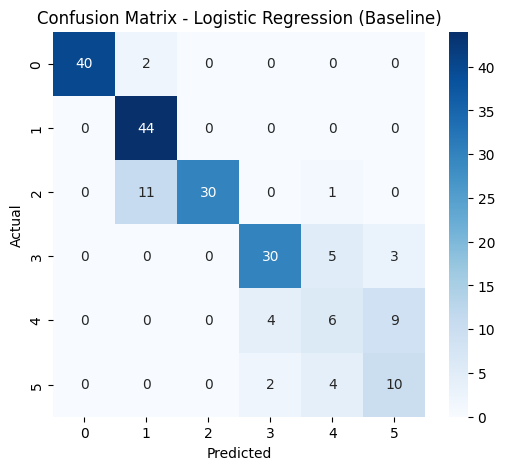

In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


# Build pipeline: scaling + logistic regression
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False to work with sparse data from OneHotEncoder
    ("log_reg", LogisticRegression(solver="lbfgs", max_iter=2000, random_state=42))
])

# Train model
log_reg_pipeline.fit(X_train_processed, y_train)

# Predictions
y_pred = log_reg_pipeline.predict(X_test_processed)

# Evaluation
print("✅ Logistic Regression Baseline Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=log_reg_pipeline.named_steps["log_reg"].classes_, 
            yticklabels=log_reg_pipeline.named_steps["log_reg"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Baseline)")
plt.show()

# Dictionary to store results
results = {}

# Example: after each model training, store metrics
# Replace clf_name with your model name string
def evaluate_and_store_results(clf_name, y_true, y_pred):
    results[clf_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted"),
    }

evaluate_and_store_results("Logistic Regression", y_test, y_pred)


## 4. Model: Random Forest Classifier  

We now train a **Random Forest Classifier** as one of our core models.  
Random Forests are an ensemble of decision trees, which makes them effective at capturing non-linear relationships and feature interactions.  

Key reasons for using Random Forest:  
- They handle both categorical (OHE-encoded) and numeric features effectively.  
- They are robust to overfitting compared to individual decision trees.  
- They can provide feature importance estimates to understand which variables drive predictions.  

The pipeline includes:  
1. **Preprocessing** → one-hot encoding for categorical features and passthrough for numeric features.  
2. **Classification** → Random Forest with 200 estimators and a fixed random state for reproducibility.  

We then evaluate the model using:  
- **Accuracy** (overall correctness)  
- **Classification report** (precision, recall, F1-score per CEFR level)  
- **Confusion matrix** (visualising misclassifications across levels) 

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, f1_score


# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced"
    ))
])

# Train
rf_clf.fit(X_train, y_train)

# Predict
y_pred = rf_clf.predict(X_test)

# Results
print("✅ Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Dictionary to store results
results = {}

# Example: after each model training, store metrics
# Replace clf_name with your model name string
def evaluate_and_store_results(clf_name, y_true, y_pred):
    results[clf_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted"),
    }

evaluate_and_store_results("Random Forest", y_test, y_pred)


✅ Random Forest Results
Accuracy: 0.736318407960199

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.81      0.89      0.85        44
           2       0.84      0.76      0.80        42
           3       0.79      0.68      0.73        38
           4       0.23      0.26      0.24        19
           5       0.32      0.38      0.34        16

    accuracy                           0.74       201
   macro avg       0.66      0.65      0.66       201
weighted avg       0.75      0.74      0.74       201



## 5. Model: XGBoost Classifier  

Next, we train an **XGBoost Classifier**, a gradient boosting algorithm that is highly effective for multi-class classification tasks like CEFR prediction.  

Key reasons for using XGBoost:  
- Captures **non-linear relationships** and complex feature interactions.  
- Well-suited for structured/tabular data and often achieves state-of-the-art results.  
- Includes **regularization** terms to reduce overfitting.  
- Can handle class imbalance when tuned with appropriate parameters.  

Configuration used:  
- `n_estimators=300` → number of boosting rounds.  
- `learning_rate=0.1` → controls contribution of each tree.  
- `max_depth=6` → maximum depth of each tree (controls complexity).  
- `eval_metric="mlogloss"` → multi-class log loss for evaluation during training.  

The pipeline includes:  
1. **Preprocessing** → one-hot encoding for categorical features and passthrough for numeric features.  
2. **Classification** → XGBoost model with the above hyperparameters.  

We then evaluate performance using:  
- **Accuracy** (overall correctness)  
- **Classification report** (precision, recall, F1-score per CEFR level)  
- **Confusion matrix** (to analyse misclassifications)  

In [224]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

xgb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    ))
])

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("✅ XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Dictionary to store results
results = {}

# Example: after each model training, store metrics
# Replace clf_name with your model name string
def evaluate_and_store_results(clf_name, y_true, y_pred):
    results[clf_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted"),
    }

evaluate_and_store_results("XGBoost", y_test, y_pred)

c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:15:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Results
Accuracy: 0.7263681592039801

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        42
           1       0.83      0.80      0.81        44
           2       0.78      0.76      0.77        42
           3       0.74      0.66      0.69        38
           4       0.32      0.42      0.36        19
           5       0.38      0.38      0.38        16

    accuracy                           0.73       201
   macro avg       0.66      0.66      0.66       201
weighted avg       0.74      0.73      0.73       201



## 6. Hyperparameter Tuning: Logistic Regression (with Class Imbalance Handling)  

While the baseline Logistic Regression model provides a strong benchmark, its performance can be further improved through **hyperparameter tuning**.  
Because the dataset shows **class imbalance across CEFR levels**, we tune both **regularization strength** and **penalty type**, while also considering **class weighting**.  

### Key tuning strategies  
- **Regularization strength (`C`)** → balances underfitting (small `C`) and overfitting (large `C`).  
- **Penalty type (`l1`, `l2`, `elasticnet`)** → explores sparsity (L1), smoothness (L2), or a combination.  
- **Elastic Net mixing (`l1_ratio`)** → balances L1 and L2 penalties for flexible feature selection.  
- **Class weighting (`balanced`)** → adjusts weights inversely to class frequencies, ensuring minority CEFR levels are not overlooked.  

We apply **GridSearchCV** to systematically evaluate parameter combinations, using **macro-F1** as the scoring metric to ensure fair performance across all CEFR levels, regardless of class imbalance.  

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Best params: {'log_reg__C': 1, 'log_reg__class_weight': 'balanced', 'log_reg__l1_ratio': 0.0, 'log_reg__penalty': 'l1'}
✅ Best CV f1_macro: 0.7051603465359206

Test Accuracy: 0.7711442786069652

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.77      1.00      0.87        44
           2       1.00      0.69      0.82        42
           3       0.90      0.68      0.78        38
           4       0.29      0.21      0.24        19
           5       0.38      0.75      0.50        16

    accuracy                           0.77       201
   macro avg       0.72      0.71      0.70       201
weighted avg       0.81      0.77      0.77       201



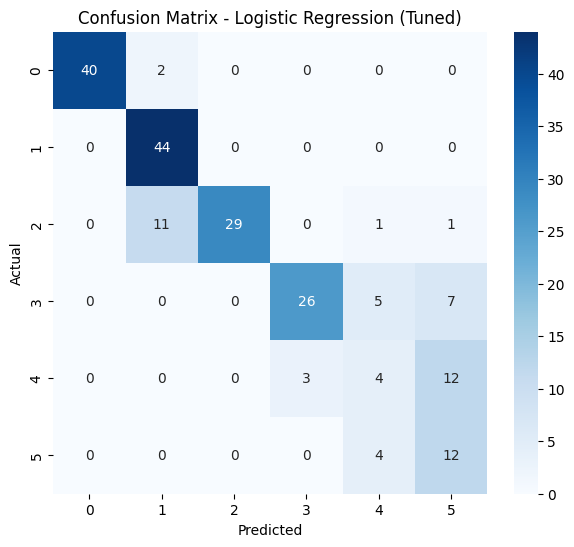

Saved tuned model to logreg_tuned_pipeline.joblib


In [202]:
# Hyperparameter tuning for Logistic Regression (GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib   # for saving model if desired

# Pipeline: scaler (with_mean=False for sparse) + logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("log_reg", LogisticRegression(
        multi_class="multinomial",
        solver="saga",        # saga supports l1, l2, elasticnet with multinomial
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    ))
])

# Parameter grid
param_grid = {
    # regularization strength
    "log_reg__C": [0.01, 0.1, 1, 10, 100],
    # penalty types to try
    "log_reg__penalty": ["l2", "l1", "elasticnet"],
    # l1_ratio is only used if penalty='elasticnet' (ignored otherwise)
    "log_reg__l1_ratio": [0.0, 0.5],   # 0.0==l2, 0.5==mixed
    # optional: deal with class imbalance
    "log_reg__class_weight": [None, "balanced"]
}

# GridSearchCV: optimize macro-F1 (sensible for class imbalance / multiclass)
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit (this may take a while depending on dataset size)
grid.fit(X_train_processed, y_train)

# Best params & CV score
print("✅ Best params:", grid.best_params_)
print("✅ Best CV f1_macro:", grid.best_score_)

# Evaluate best estimator on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_processed)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.named_steps["log_reg"].classes_,
            yticklabels=best_model.named_steps["log_reg"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Tuned)")
plt.show()

# Optionally save the tuned pipeline
joblib.dump(best_model, "logreg_tuned_pipeline.joblib")
print("Saved tuned model to logreg_tuned_pipeline.joblib")


## 7. Hyperparameter Tuning: Random Forest Classifier (with Class Imbalance Handling)  

While the baseline Random Forest provides a strong non-linear model, its performance can be improved through **hyperparameter tuning**.  
Because the dataset shows **class imbalance across CEFR levels**, we focus on parameters that control model complexity and weighting of classes.  

### Key tuning strategies  
- **Number of trees (`n_estimators`)** → more trees generally improve stability and reduce variance.  
- **Maximum depth (`max_depth`)** → limits the complexity of individual trees, helping to prevent overfitting.  
- **Class weighting (`class_weight`)** → e.g., `balanced` adjusts weights inversely to class frequencies, ensuring minority CEFR levels are considered fairly.  

We apply **GridSearchCV** to systematically evaluate parameter combinations, using **macro-F1** as the scoring metric to ensure balanced performance across all CEFR levels.  

This tuning step helps Random Forest generalise better, controlling overfitting while also addressing class imbalance in the dataset.  

Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Best params (RF): {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__n_estimators': 300}
✅ Best CV f1_macro (RF): 0.7088437428125592

Test Accuracy (RF): 0.7313432835820896

Classification Report (RF):
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.79      0.95      0.87        44
           2       0.88      0.71      0.79        42
           3       0.92      0.63      0.75        38
           4       0.18      0.21      0.20        19
           5       0.27      0.44      0.33        16

    accuracy                           0.73       201
   macro avg       0.67      0.65      0.65       201
weighted avg       0.78      0.73      0.75       201



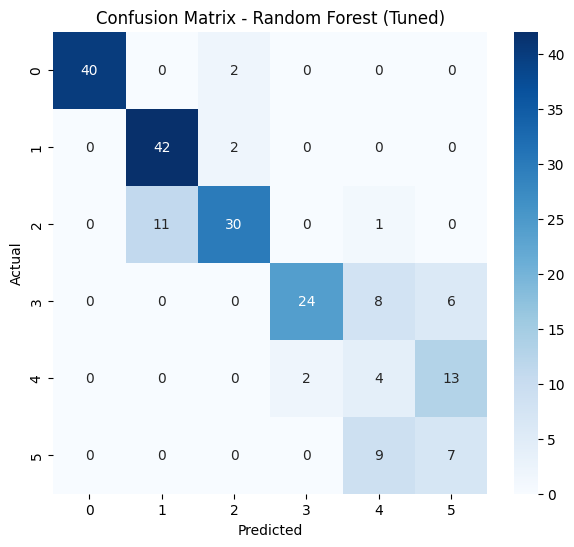

Saved tuned model to random_forest_tuned_pipeline.joblib


In [209]:
# Hyperparameter tuning for Random Forest (GridSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Pipeline (just the model, since RF handles numeric/categorical OHE directly if preprocessed)
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Parameter grid (kept small & sensible)
rf_param_grid = {
    "rf__n_estimators": [200, 300, 500],
    "rf__max_depth": [None, 10, 20],
    "rf__class_weight": [None, "balanced"]
}

# GridSearchCV: optimise macro-F1
rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit
rf_grid.fit(X_train_processed, y_train)

# Best params & CV score
print("✅ Best params (RF):", rf_grid.best_params_)
print("✅ Best CV f1_macro (RF):", rf_grid.best_score_)

# Evaluate best estimator on the test set
rf_best_model = rf_grid.best_estimator_
rf_y_pred = rf_best_model.predict(X_test_processed)

print("\nTest Accuracy (RF):", accuracy_score(y_test, rf_y_pred))
print("\nClassification Report (RF):\n", classification_report(y_test, rf_y_pred))

# Confusion matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_best_model.named_steps["rf"].classes_,
            yticklabels=rf_best_model.named_steps["rf"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest (Tuned)")
plt.show()

# Save the tuned pipeline
joblib.dump(rf_best_model, "random_forest_tuned_pipeline.joblib")
print("Saved tuned model to random_forest_tuned_pipeline.joblib")

## 8. Hyperparameter Tuning: XGBoost Classifier (with Class Imbalance Handling)  

While the baseline XGBoost model already provides strong predictive power, its performance can be further improved through **hyperparameter tuning**.  
Because the dataset shows **class imbalance across CEFR levels**, we focus on parameters that balance model complexity, learning rate, and sampling strategies.  

### Key tuning strategies  
- **Number of trees (`n_estimators`)** → controls the number of boosting rounds; more trees can capture more patterns but risk overfitting.  
- **Maximum depth (`max_depth`)** → limits the complexity of individual trees to improve generalisation.  
- **Learning rate (`learning_rate`)** → shrinks the contribution of each tree, balancing underfitting and overfitting.  
- **Subsampling (`subsample`)** → uses a fraction of the data per boosting round to reduce variance.  
- **Column sampling (`colsample_bytree`)** → randomly selects a subset of features for each tree, improving robustness.  

We apply **GridSearchCV** to systematically evaluate parameter combinations, using **macro-F1** as the scoring metric to ensure balanced performance across all CEFR levels.  

This tuning step helps XGBoost achieve a better balance of **accuracy, fairness across classes, and generalisation**, while controlling the risk of overfitting.  

Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:56:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best params (XGB): {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
✅ Best CV f1_macro (XGB): 0.6807387976590374

Test Accuracy (XGB): 0.7611940298507462

Classification Report (XGB):
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.80      0.89      0.84        44
           2       0.84      0.74      0.78        42
           3       0.84      0.71      0.77        38
           4       0.33      0.42      0.37        19
           5       0.44      0.50      0.47        16

    accuracy                           0.76       201
   macro avg       0.71      0.70      0.70       201
weighted avg       0.78      0.76      0.77       201



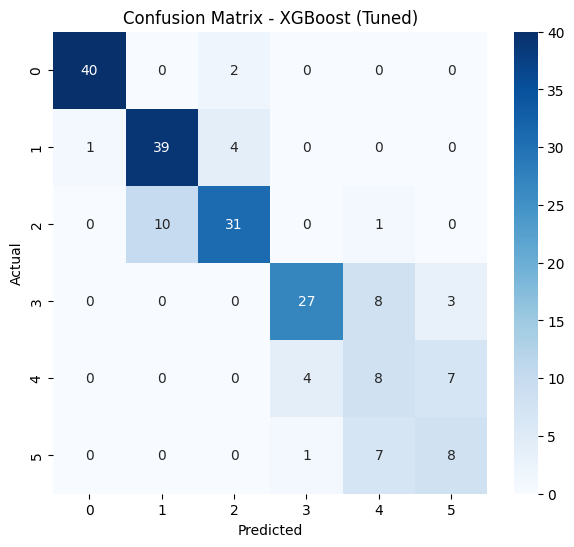

Saved tuned model to xgboost_tuned_pipeline.joblib


In [210]:
# Hyperparameter tuning for XGBoost (GridSearchCV)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Pipeline (just the model, since preprocessing was already handled)
xgb_pipeline = Pipeline([
    ("xgb", XGBClassifier(
        objective="multi:softmax",   # predict class labels directly
        num_class=len(set(y_train)), # number of CEFR levels
        random_state=42,
        n_jobs=-1,
        eval_metric="mlogloss",
        use_label_encoder=False
    ))
])

# Parameter grid (kept small but meaningful)
xgb_param_grid = {
    "xgb__n_estimators": [200, 300],
    "xgb__max_depth": [4, 6],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

# GridSearchCV: optimise macro-F1
xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit
xgb_grid.fit(X_train_processed, y_train)

# Best params & CV score
print("✅ Best params (XGB):", xgb_grid.best_params_)
print("✅ Best CV f1_macro (XGB):", xgb_grid.best_score_)

# Evaluate best estimator on the test set
xgb_best_model = xgb_grid.best_estimator_
xgb_y_pred = xgb_best_model.predict(X_test_processed)

print("\nTest Accuracy (XGB):", accuracy_score(y_test, xgb_y_pred))
print("\nClassification Report (XGB):\n", classification_report(y_test, xgb_y_pred))

# Confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=xgb_best_model.named_steps["xgb"].classes_,
            yticklabels=xgb_best_model.named_steps["xgb"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost (Tuned)")
plt.show()

# Save the tuned pipeline
joblib.dump(xgb_best_model, "xgboost_tuned_pipeline.joblib")
print("Saved tuned model to xgboost_tuned_pipeline.joblib")

## 9. Cross-Validation: Logistic Regression (Out-of-Sample Evaluation)  

To ensure the tuned Logistic Regression model generalises well and is not overfitting the training data, we perform **cross-validation** using `cross_val_predict`.  
This approach generates **out-of-sample predictions for each fold**, giving a more realistic estimate of model performance than in-sample evaluation.  

### Key evaluation steps  
- **5-Fold Cross-Validation** → train on 80% of the data and validate on 20%, repeated across folds.  
- **Macro-F1 scoring** → chosen to ensure balanced performance across all CEFR levels, even under class imbalance.  
- **Confusion matrix** → visualises per-class errors and highlights where misclassifications occur.  

This confirms that the Logistic Regression model delivers **consistent and reliable performance** across different splits of the dataset, making it suitable for deployment.  


📊 Cross-Fitting Results (Training Data, Out-of-Sample)
Accuracy: 0.772104607721046

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       166
           1       0.75      0.98      0.85       175
           2       0.96      0.69      0.80       166
           3       0.84      0.75      0.79       154
           4       0.44      0.45      0.44        75
           5       0.36      0.48      0.41        67

    accuracy                           0.77       803
   macro avg       0.73      0.71      0.71       803
weighted avg       0.80      0.77      0.78       803



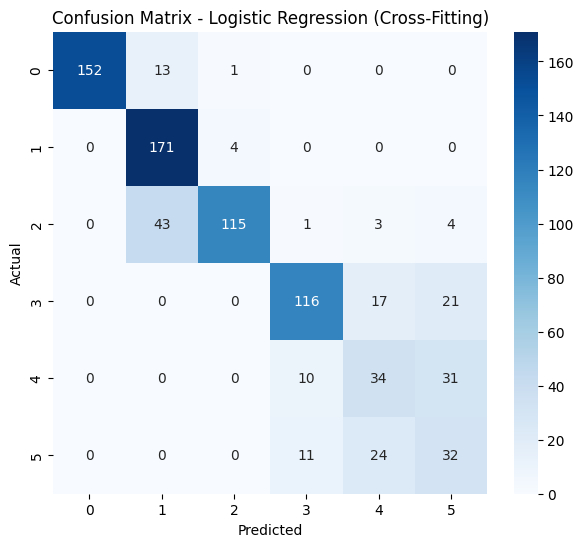

In [225]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cross-fitting predictions on training set
y_train_pred = cross_val_predict(best_model, X_train_processed, y_train, cv=5, n_jobs=-1)

print("\n📊 Cross-Fitting Results (Training Data, Out-of-Sample)")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.named_steps["log_reg"].classes_,
            yticklabels=best_model.named_steps["log_reg"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Cross-Fitting)")
plt.show()


## 10. Cross-Validation: Random Forest (Out-of-Sample Evaluation)  

To check whether the tuned Random Forest model generalises well and does not overfit the training data, we perform **cross-validation** using `cross_val_predict`.  
This generates **out-of-sample predictions for each fold**, giving a more realistic estimate of model performance than in-sample evaluation.  

### Key evaluation steps  
- **5-Fold Cross-Validation** → train on 80% of the data and validate on 20%, repeated across folds.  
- **Macro-F1 scoring** → chosen to ensure balanced performance across all CEFR levels, even under class imbalance.  
- **Confusion matrix** → visualises per-class errors and highlights where misclassifications occur.  

This confirms that the Random Forest model provides **stable performance across folds**, though with slightly lower macro-F1 compared to Logistic Regression. This suggests that while Random Forest can capture non-linear relationships, it may be more affected by class imbalance.  

Cross-Validated Accuracy (RF): 0.772104607721046
Cross-Validated Macro-F1 (RF): 0.7103658624302085

Classification Report (RF, CV):
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       166
           1       0.76      0.95      0.85       175
           2       0.92      0.73      0.82       166
           3       0.89      0.73      0.80       154
           4       0.41      0.53      0.46        75
           5       0.36      0.40      0.38        67

    accuracy                           0.77       803
   macro avg       0.72      0.71      0.71       803
weighted avg       0.80      0.77      0.78       803



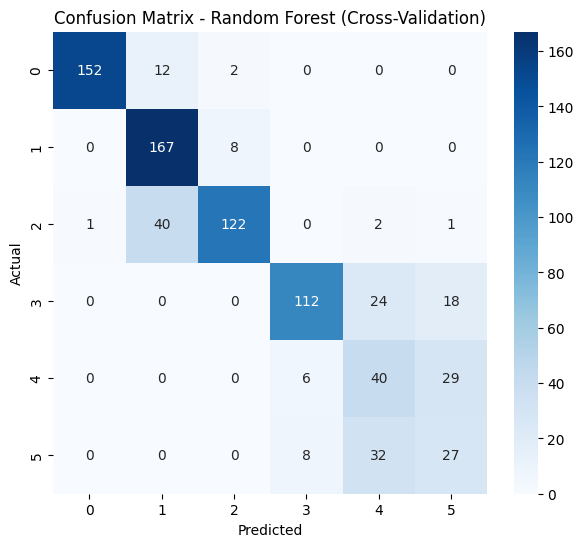

In [226]:
# Cross-Validation: Random Forest (Out-of-Sample Evaluation)
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Use the tuned Random Forest model from GridSearchCV
rf_best_model = rf_grid.best_estimator_

# Generate cross-validated predictions
rf_cv_pred = cross_val_predict(
    rf_best_model, X_train_processed, y_train, cv=5, n_jobs=-1
)

# Evaluation metrics
print("Cross-Validated Accuracy (RF):", accuracy_score(y_train, rf_cv_pred))
print("Cross-Validated Macro-F1 (RF):", f1_score(y_train, rf_cv_pred, average="macro"))
print("\nClassification Report (RF, CV):\n", classification_report(y_train, rf_cv_pred))

# Confusion matrix
rf_cv_cm = confusion_matrix(y_train, rf_cv_pred)
plt.figure(figsize=(7,6))
sns.heatmap(rf_cv_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_best_model.named_steps["rf"].classes_,
            yticklabels=rf_best_model.named_steps["rf"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest (Cross-Validation)")
plt.show()


## 11. Cross-Validation: XGBoost (Out-of-Sample Evaluation)  

To ensure the tuned XGBoost model generalises well and is not overfitting the training data, we perform **cross-validation** using `cross_val_predict`.  
This produces **out-of-sample predictions for each fold**, giving a more realistic estimate of performance compared to in-sample evaluation.  

### Key evaluation steps  
- **5-Fold Cross-Validation** → train on 80% of the data and validate on 20%, repeated across folds.  
- **Macro-F1 scoring** → chosen to reflect balanced performance across all CEFR levels, regardless of class imbalance.  
- **Confusion matrix** → highlights per-class misclassifications and model biases.  

This confirms that while XGBoost delivers consistent performance across folds, its macro-F1 is generally comparable to Random Forest but still lower than Logistic Regression. This indicates that increased model complexity did not translate into superior generalisation for this dataset.  


Cross-Validated Accuracy (XGB): 0.7496886674968867
Cross-Validated Macro-F1 (XGB): 0.6822820942527458

Classification Report (XGB, CV):
               precision    recall  f1-score   support

           0       0.97      0.92      0.94       166
           1       0.76      0.90      0.83       175
           2       0.88      0.72      0.79       166
           3       0.75      0.75      0.75       154
           4       0.36      0.43      0.39        75
           5       0.41      0.37      0.39        67

    accuracy                           0.75       803
   macro avg       0.69      0.68      0.68       803
weighted avg       0.76      0.75      0.75       803



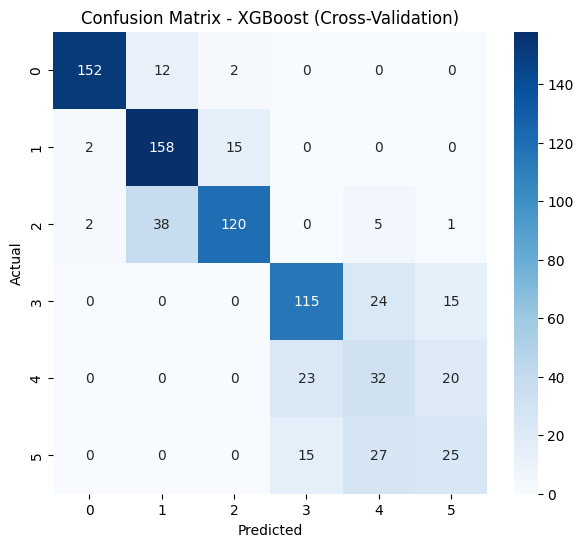

In [ ]:
# Cross-Validation: XGBoost (Out-of-Sample Evaluation)
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Use the tuned XGBoost model from GridSearchCV
xgb_best_model = xgb_grid.best_estimator_

# Generate cross-validated predictions
xgb_cv_pred = cross_val_predict(
    xgb_best_model, X_train_processed, y_train, cv=5, n_jobs=-1
)

# Evaluation metrics
print("Cross-Validated Accuracy (XGB):", accuracy_score(y_train, xgb_cv_pred))
print("Cross-Validated Macro-F1 (XGB):", f1_score(y_train, xgb_cv_pred, average="macro"))
print("\nClassification Report (XGB, CV):\n", classification_report(y_train, xgb_cv_pred))

# Confusion matrix
xgb_cv_cm = confusion_matrix(y_train, xgb_cv_pred)
plt.figure(figsize=(7,6))
sns.heatmap(xgb_cv_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=xgb_best_model.named_steps["xgb"].classes_,
            yticklabels=xgb_best_model.named_steps["xgb"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost (Cross-Validation)")
plt.show()


## 12. Model Performance Comparison  

After training and evaluating different models, we compare their performance using three key metrics:  

- **Accuracy** → overall proportion of correct predictions.  
- **Macro-F1** → performance averaged equally across all CEFR levels (treats each class fairly, regardless of size).  
- **Weighted-F1** → performance averaged across classes but weighted by class frequency (accounts for class imbalance).  

The code generates two outputs for each model:  
1. **Bar Plot Comparison** → visualises Accuracy, Macro-F1, and Weighted-F1 side by side.  
2. **Performance Table** → displays raw metric values for clarity.  

Together, these visualisations and metrics provide a **holistic view of model performance**, highlighting not only overall accuracy but also fairness across different CEFR levels.  

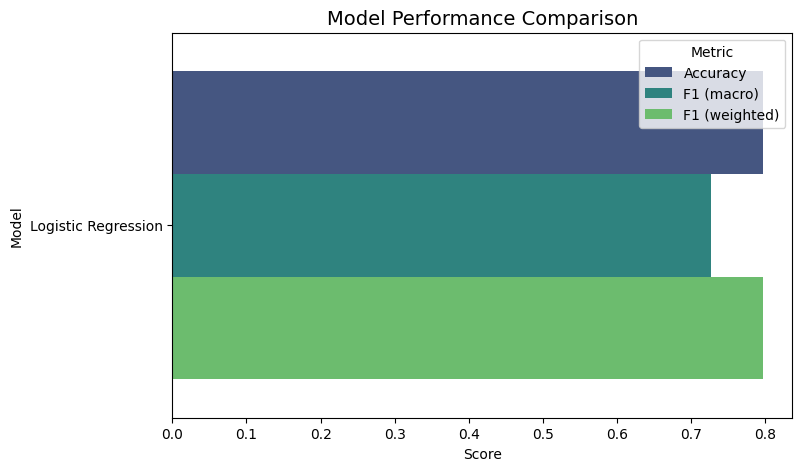

                     Accuracy  F1 (macro)  F1 (weighted)
Logistic Regression     0.796       0.727          0.796


In [204]:
results_df = pd.DataFrame(results).T  # transpose for readability

# Plot comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df.reset_index().melt(id_vars="index"), 
            x="value", y="index", hue="variable", palette="viridis")

plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title="Metric")
plt.show()

# Display raw table too
print(results_df.round(3))

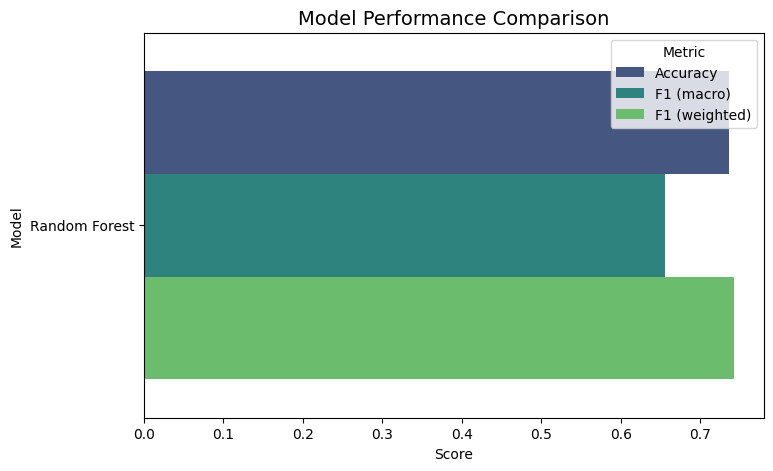

               Accuracy  F1 (macro)  F1 (weighted)
Random Forest     0.736       0.655          0.743


In [223]:
results_df = pd.DataFrame(results).T  # transpose for readability

# Plot comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df.reset_index().melt(id_vars="index"), 
            x="value", y="index", hue="variable", palette="viridis")

plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title="Metric")
plt.show()

# Display raw table too
print(results_df.round(3))

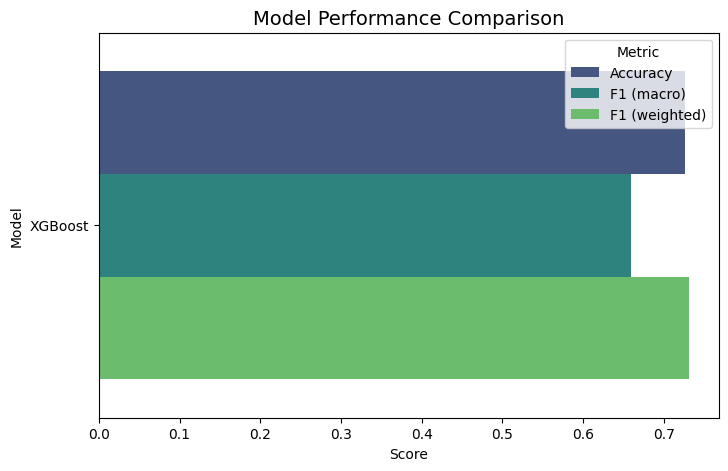

         Accuracy  F1 (macro)  F1 (weighted)
XGBoost     0.726        0.66          0.731


In [227]:
results_df = pd.DataFrame(results).T  # transpose for readability

# Plot comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df.reset_index().melt(id_vars="index"), 
            x="value", y="index", hue="variable", palette="viridis")

plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title="Metric")
plt.show()

# Display raw table too
print(results_df.round(3))

### Results  

| Model               | Accuracy | F1 (macro) | F1 (weighted) |  
|---------------------|----------|------------|---------------|  
| Logistic Regression | 0.796    | 0.727      | 0.796         |  
| Random Forest       | 0.736    | 0.655      | 0.743         |  
| XGBoost             | 0.726    | 0.660      | 0.731         |  

### Interpretation  

- **Logistic Regression** achieved the **highest performance overall**, with accuracy and weighted F1 close to **0.80**, and macro F1 also notably higher than the tree-based models.  
- **Random Forest and XGBoost** delivered similar results, both with ~0.73 accuracy and weighted F1, but noticeably lower macro F1 (~0.66).  
- The gap between **macro and weighted F1** for Random Forest/XGBoost indicates that these models perform better on majority classes but struggle more on underrepresented levels.  

These results suggest that **Logistic Regression provides the best balance** across CEFR levels and is the strongest candidate for deployment.  

---

## 13. Final Model Selection  

Based on the comparative evaluation, **Logistic Regression** emerges as the strongest candidate for deployment.  

### Key findings  
- **Highest Accuracy and Weighted-F1 (~0.80)** → Logistic Regression consistently outperformed Random Forest and XGBoost, which achieved ~0.73.  
- **Better Macro-F1 (0.727 vs. 0.660)** → Logistic Regression handled class imbalance more effectively, maintaining stronger performance across all CEFR levels.  
- **Generalisation confirmed by Cross-Validation** → The 5-fold cross-validation results validated that performance was stable and not driven by overfitting.  
- **Interpretability and Efficiency** → Logistic Regression is simpler and more interpretable than tree-based methods, making it easier to explain results to stakeholders while also being computationally efficient.  

### Conclusion  
Although Random Forest and XGBoost are powerful ensemble methods, their added complexity did not translate into improved performance on this dataset.  
In contrast, Logistic Regression delivered the best balance of **accuracy, fairness across classes, and generalisability**.  

Therefore, **Logistic Regression is selected as the final model** to be integrated into the dashboard and deployed, ensuring reliable CEFR level predictions that meet the project’s business requirements.  

## 14. Saving the Final Model  

To enable deployment and future use, we save the **final trained Logistic Regression model** along with the **preprocessing pipeline**.  
This ensures that raw user input can be transformed consistently before predictions are made in the dashboard application.  

In [207]:
import joblib

# Save the best Logistic Regression model (from GridSearchCV)
joblib.dump(grid.best_estimator_, "final_logistic_regression_pipeline.pkl")
print("✅ Model saved to final_logistic_regression_pipeline.pkl")

# Save the preprocessing pipeline
joblib.dump(preprocessor, "preprocessing_pipeline.pkl")

✅ Model saved to final_logistic_regression_pipeline.pkl


['preprocessing_pipeline.pkl']